Задание: провести разведочный анализ данных, придумать продуктовые и технические гипотезы — какую ценность можете извлечь из данных для организации, которая предоставила данные.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('/content/transaction_fraud_data (1).parquet')
exchange_rate = pd.read_parquet('/content/historical_currency_exchange (1).parquet')

In [4]:
df

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483761,TX_58a762fa,CUST_11344,377055034743699,2024-10-30 23:59:58.926575,Retail,online,AliExpress,887.32,SGD,Singapore,...,False,Safari,web,2e37bb086e754bfaf2ec3806dcac8d98,248.8.111.152,False,False,False,"{'num_transactions': 1, 'total_amount': 1521.7...",False
7483762,TX_dabcf671,CUST_38961,373625915641065,2024-10-30 23:59:58.950801,Grocery,physical,Kroger,356.06,EUR,France,...,False,Chrome,web,459c67dbfbb15019df8088fc0f2ffe1d,224.123.137.90,False,False,False,"{'num_transactions': 0, 'total_amount': 356.06...",False
7483763,TX_ab567eb4,CUST_75576,6702342842796660,2024-10-30 23:59:58.972155,Grocery,physical,Kroger,391.96,SGD,Singapore,...,False,Safari,web,337d36a8f5e811564a1dd3c255db01dd,31.196.9.234,False,False,False,"{'num_transactions': 0, 'total_amount': 391.96...",False
7483764,TX_5ae61846,CUST_82508,374615717295581,2024-10-30 23:59:58.996608,Retail,online,eBay,601.71,USD,USA,...,False,Firefox,web,52874c17f4ab0846fac1aed0c66e8551,188.74.107.8,False,False,False,"{'num_transactions': 2, 'total_amount': 1474.5...",False


Посмотрим сколько мошеннических операций из всех транзакций

In [5]:
print(df['is_fraud'].mean())

0.19972818498066347


Проверим с какими признаками наиболее коррелирует признак is_fraud

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

Распарсим last_hour_activity в столбцы

In [7]:
last_hour_cols = pd.json_normalize(df['last_hour_activity'])
df = pd.concat([df.drop('last_hour_activity', axis=1), last_hour_cols], axis=1)


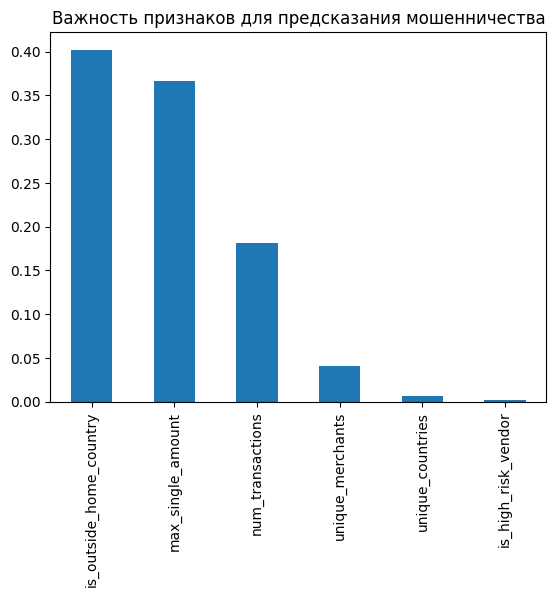

In [10]:
X = df[['is_outside_home_country', 'is_high_risk_vendor', 'max_single_amount',
                 'num_transactions', 'unique_countries', 'unique_merchants']]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
model.fit(X_train, y_train)

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Важность признаков для предсказания мошенничества')
plt.show()

Проанализируем насколько больше мошеннических операций происходит если перевод происходит за границей чем внутри страны

Доля мошенничества по гео транзакции is_outside_home_country
False    0.024902
True     0.567753
Name: is_fraud, dtype: float64


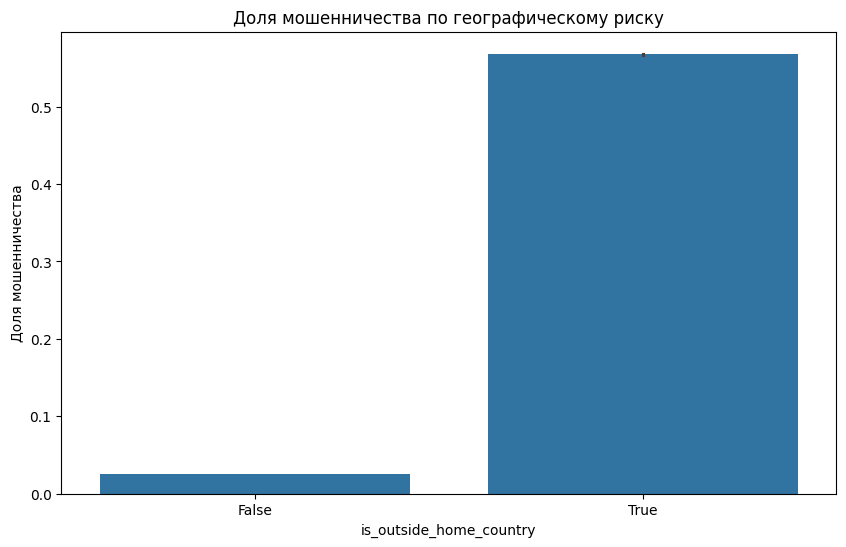

In [13]:
geo_risk = df.groupby('is_outside_home_country')['is_fraud'].mean()
print('Доля мошенничества по гео транзакции', geo_risk)

plt.figure(figsize=(10, 6))
sns.barplot(x='is_outside_home_country', y='is_fraud', data=df)
plt.title('Доля мошенничества по географическому риску')
plt.ylabel('Доля мошенничества')
plt.show()

Проанализируем мошенничество по дню и времени суток

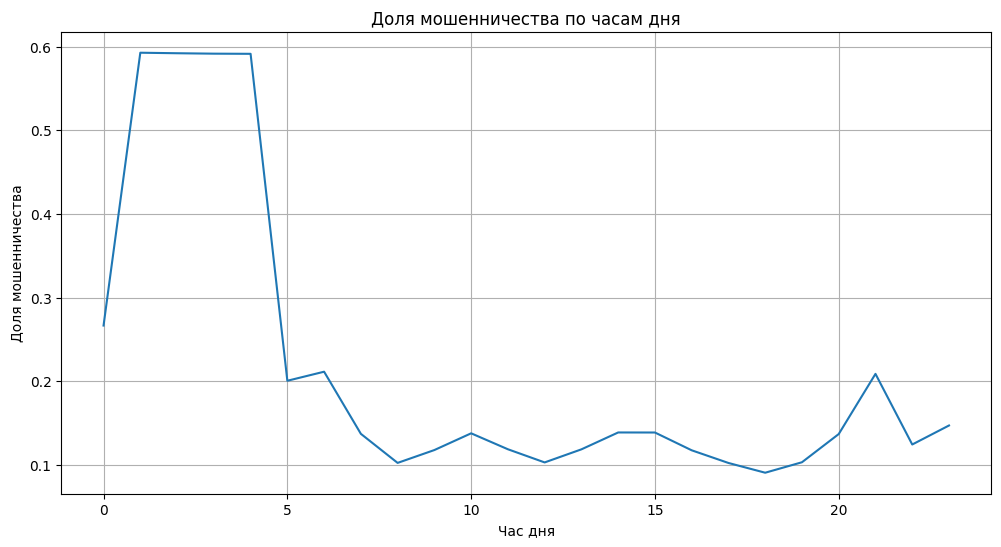

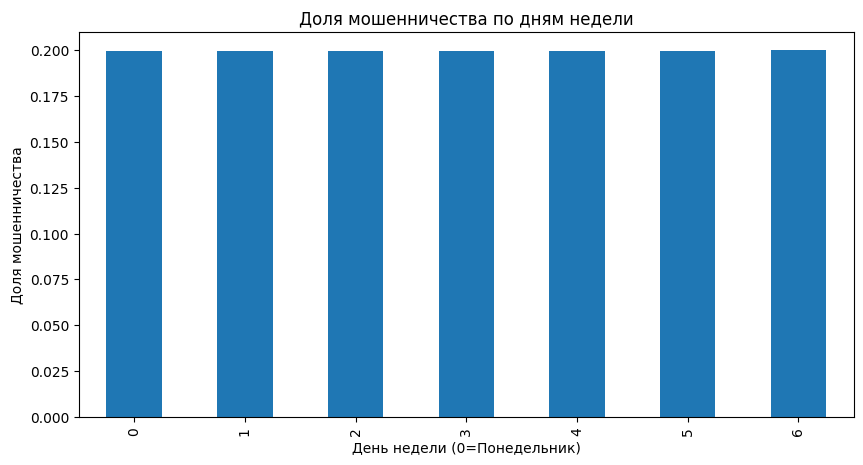

In [14]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5

hourly_fraud = df.groupby('hour')['is_fraud'].mean()
plt.figure(figsize=(12, 6))
hourly_fraud.plot()
plt.title('Доля мошенничества по часам дня')
plt.ylabel('Доля мошенничества')
plt.xlabel('Час дня')
plt.grid()
plt.show()

weekday_fraud = df.groupby('day_of_week')['is_fraud'].mean()
plt.figure(figsize=(10, 5))
weekday_fraud.plot(kind='bar')
plt.title('Доля мошенничества по дням недели')
plt.ylabel('Доля мошенничества')
plt.xlabel('День недели (0=Понедельник)')
plt.show()